In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import math

In [ ]:
class PossibleContour:
  def __init__(self, _x1, _y1, _x2, _y2, _area):
    self.x1 = _x1
    self.y1 = _y1
    self.x2 = _x2
    self.y2 = _y2
    self.area = _area


In [ ]:
def removeInnerOverlappingChars(listOfContours):
  copy = list(listOfContours)
  for currentContour in copy:
    for otherContour in copy:
      if currentContour != otherContour:
        if ((currentContour.x1 <= otherContour.x1 and currentContour.x2 >= otherContour.x1) or 
            (currentContour.x1 <= otherContour.x2 and currentContour.x2 >= otherContour.x2)): 
          if ((currentContour.y1 <= otherContour.y1 and currentContour.y2 >= otherContour.y1) or 
              (currentContour.y1 <= otherContour.y2 and currentContour.y2 >= otherContour.y2)): 
            if currentContour.area > otherContour.area:
              if otherContour in copy:
                copy.remove(otherContour)
            elif currentContour.area < otherContour.area:
              if currentContour in copy:
                copy.remove(currentContour)

  return copy


In [ ]:
img = cv2.imread('/content/stones.jpeg', -1)

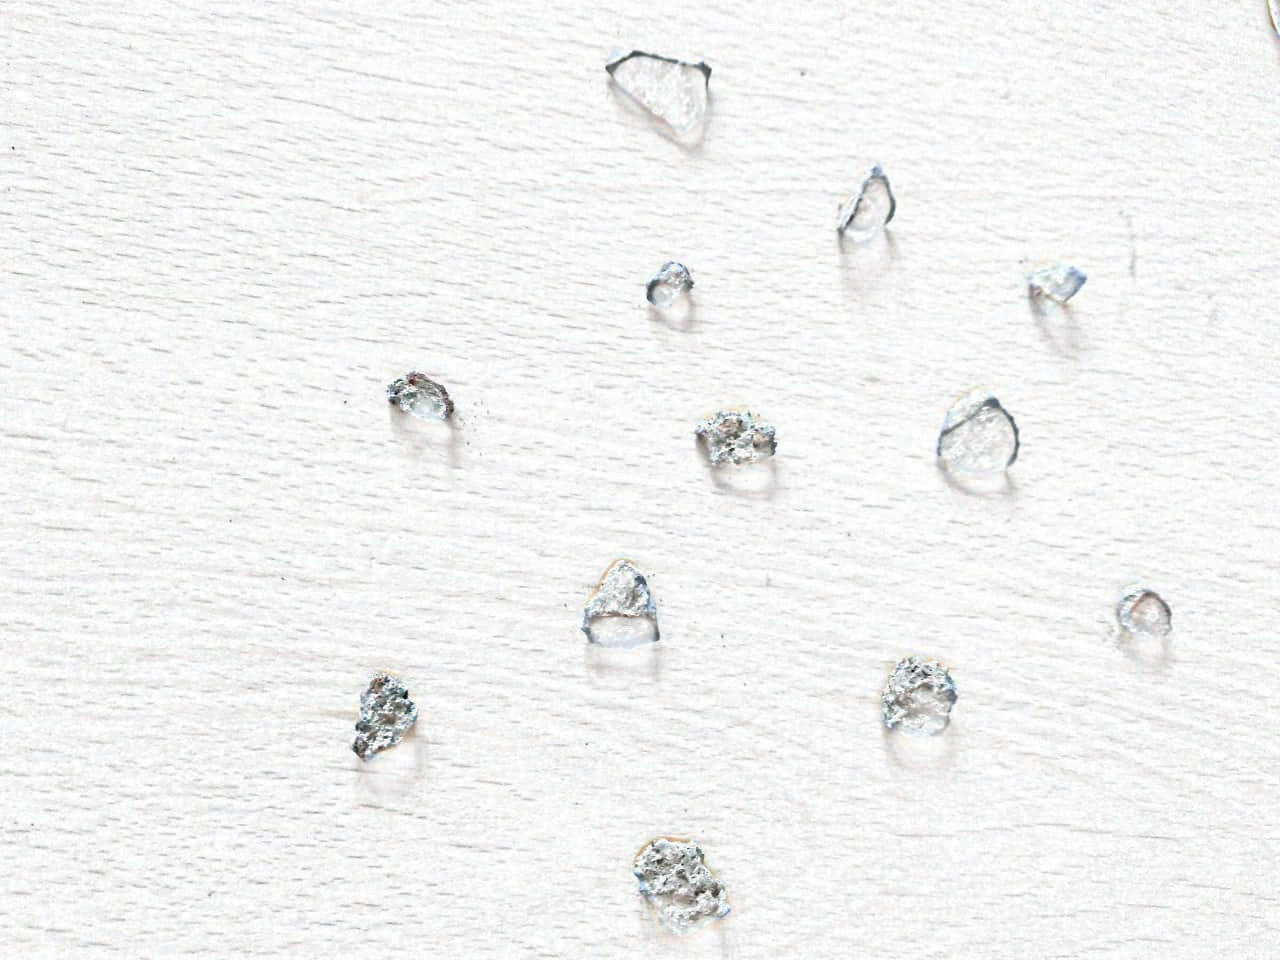

In [ ]:
rgb_planes = cv2.split(img) # Split the image into RGB plane (i.e. 3 different channels). 

result_planes = [] 
result_norm_planes = [] 
for plane in rgb_planes: # for each channel
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8)) # dilate the image so as to lighten the object present in the image. 
    bg_img = cv2.medianBlur(dilated_img, 21)  # further blur the image to make the object disappear
    
    # Now we have an image which doesn't contain the objects and just the shadow part. So subtracting this image from the original and inverting it cause we want the 
    # background to be white 
    
    diff_img = 255 - cv2.absdiff(plane, bg_img) 

    # Normalizing the image so to make it even clearer. 
    
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1) 
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

result = cv2.merge(result_planes) # merging the split planes
result_norm = cv2.merge(result_norm_planes)

# cv2_imshow(result)
cv2_imshow(result_norm)


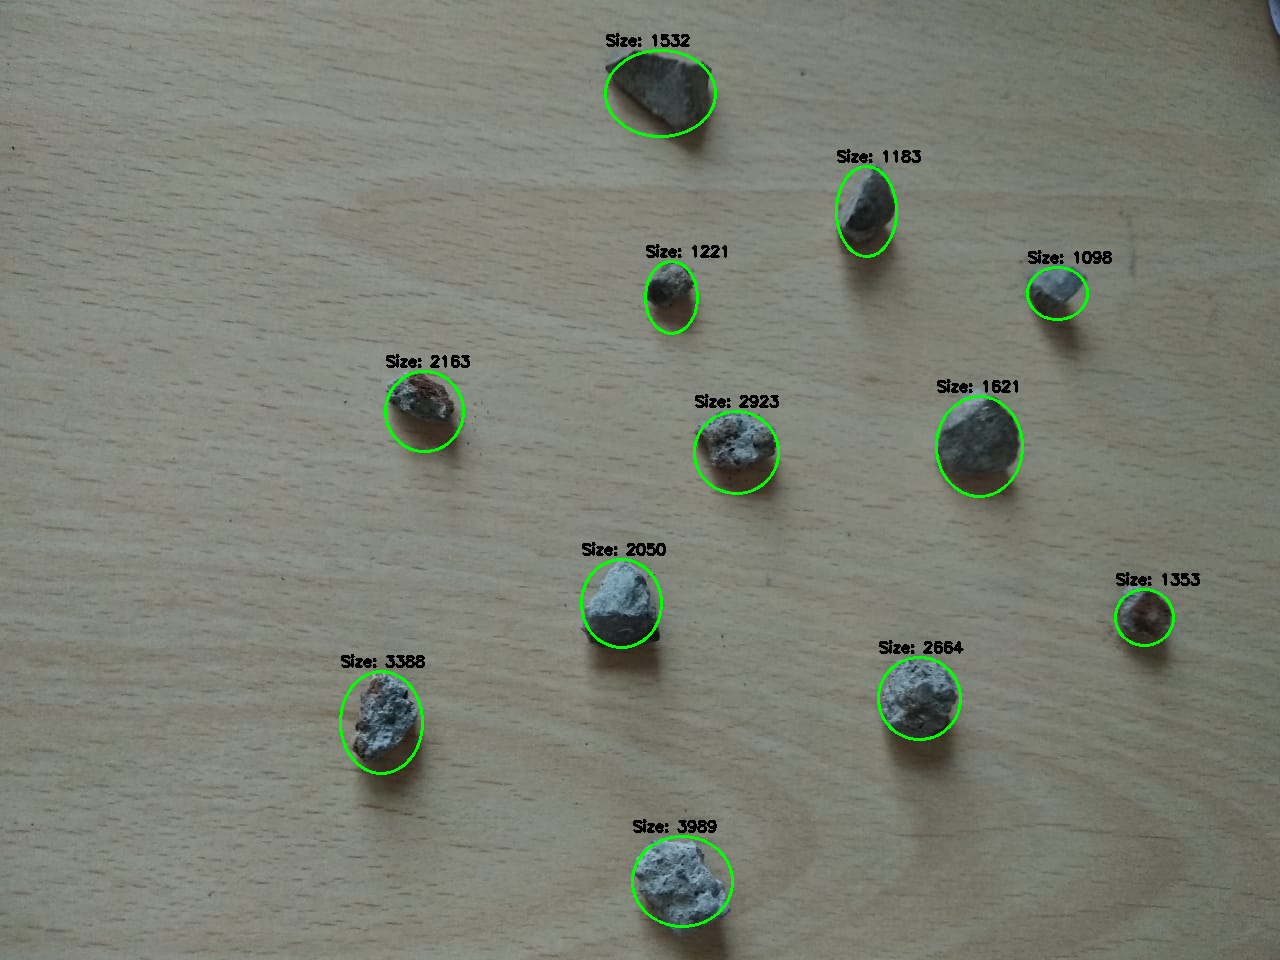

In [ ]:
contours = []
image = result_norm
original = img.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # converting image to grayscale
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]  # thresholding the image

output = cv2.connectedComponentsWithStats(thresh, 4, cv2.CV_32S) # apply connected component analysis to the thresholded image (i.e. finding connected pixels in the image)
(numLabels, labels, stats, centroids) = output # connected component analysis gives four outputs


# loop over the number of unique connected component labels, skipping over the first label (as label zero is the background)

for i in range(1, numLabels):
	# extract the connected component statistics for the current label
	x = stats[i, cv2.CC_STAT_LEFT]
	y = stats[i, cv2.CC_STAT_TOP]
	w = stats[i, cv2.CC_STAT_WIDTH]
	h = stats[i, cv2.CC_STAT_HEIGHT]
	area = stats[i, cv2.CC_STAT_AREA]

	# ensure the width, height, and area are all not too small 
	keepWidth = w > 10 
	keepHeight = h > 10 
	keepArea = area > 250 

	# ensure the connected component we are examining passes all three tests
	if all((keepWidth, keepHeight, keepArea)):
		contours.append(PossibleContour(x, y, x+w, y+h, area))   

contours = removeInnerOverlappingChars(contours) # call the removeInnerOverlappingChars function

# plot the contours which qualifies all criteria. 

for contour in contours:
  cx=math.ceil((contour.x1+contour.x2)/2)
  cy=math.ceil((contour.y1+contour.y2)/2)
  al=math.ceil(abs(contour.x1-contour.x2)/2)
  bl=math.ceil(abs(contour.y1-contour.y2)/2)
  

  cv2.ellipse(original, (cx,cy),(al,bl),0,0,360 ,(0, 255, 0), 2)
  cv2.putText(original, "Size: {}".format(contour.area), (contour.x1, contour.y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
  
cv2_imshow(original)
